# IMPORT PACKAGES

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import vector_tools as vt

# IMPORT DATA
- Use data from the raw ".dat" file and the ".sen" file to compile a comprehensive dataset

In [2]:
dat1 = vt.datfile_to_ds('ADV/DEPL_204a.dat','ADV/DEPL_204a.vhd',32)
#sen1 = vt.senfile_to_ds('ADV/DEPL_204a.sen')
dat1.to_netcdf('ADV/adv1_dat.nc')
#sen1.to_netcdf('ADV/adv1_sen.nc')

dat2 = vt.datfile_to_ds('ADV/DEP205.dat','ADV/DEP205.vhd', 32)
#sen2 = vt.senfile_to_ds('ADV/DEP205.sen')
dat2.to_netcdf('ADV/adv2_dat.nc')
#sen2.to_netcdf('ADV/adv2_sen.nc')

Importing data...
 
Creating datetime for data file...
 
Creating xarray dataset...

Importing data...
 
Creating datetime for data file...
 
Creating xarray dataset...



In [2]:
adv1 = xr.open_dataset('ADV/adv1.nc')
adv2 = xr.open_dataset('ADV/adv2.nc')

# DATA QUALITY CONTROL

In [ ]:
test = dat2.where(dat2.Dat_flag < 42)
test = test.dropna(dim = 'time', how="any")
gdat = np.unique(test.Burst_number, return_counts=True)
for i in range(len(np.unique(test.Burst_number))):
    if gdat[1][i]==38400:
        print(gdat[0][i])

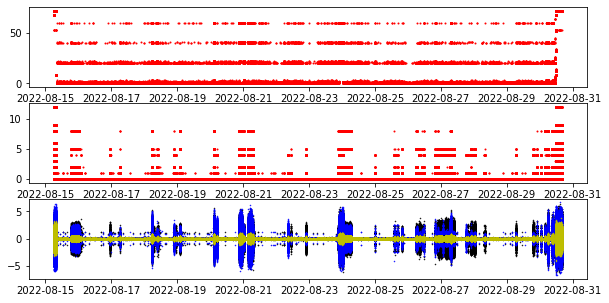

In [134]:
plt.figure(figsize = (10,5))

plt.subplot(311)
plt.plot(adv2_flagged.Datetime, adv2_flagged.Flag, '.r', ms = 2)

plt.subplot(312)
plt.plot(adv2_flagged.Datetime, adv2_flagged.Flag_pw, '.r', ms = 2)

plt.subplot(313)
plt.plot(adv2_flagged.Datetime, adv2_flagged.Nor_diff, '.k', ms = 1)
plt.plot(adv2_flagged.Datetime, adv2_flagged.Eas_diff, '.b', ms = 1)
plt.plot(adv2_flagged.Datetime, adv2_flagged.Up_diff, '.y', ms = 1)

## If phase wrapping is present
- Convert velocities from ENU to beam by using the transformation matrix in .hdr files
    - The following code is based on a MatLab script available on NORTEK's FAQ forums:
        https://support.nortekgroup.com/hc/en-us/articles/360029820971-How-is-a-coordinate-transformation-done-
        - Most relevant information is available in the .hdr file
        - You will need the transformation matrix, as well as heading, pitch, and roll data for each sample to make the conversions
    - Once velocities have been converted, calculate the ambiguous velocity V_amb
    - Run a patch over the entire BEAM velocity dataset
        - If phase wrap is negative: newvel = oldvel + 2*V_amb
        - If phase wrap is positive: newvel = oldvel - 2*V_amb
    -Convert patched velocities back to ENU for more user-friendly data

In [52]:
# Transformation matrix located in .hdr file as 'Transformation matrix'

T = np.array([[2.7249, -1.3770, -1.3503], #Convert matrix to multidimensional numpy array
   [-0.0161, 2.3442, -2.3308],
   [0.3472, 0.3455, 0.3389]])

# Heading, pitch and roll are the angles output in the data in degrees
# Convert to radians
hh = np.pi*(adv1_flagged['Heading']-90)/180 #Creates list of hh, pp, and rr for all datapoints
pp = np.pi * (adv1_flagged['Pitch']/180)
rr = np.pi * (adv1_flagged['Roll']/180)

# Generate empty arrays to be populated by resulting beam velocities
beam1 = np.empty(len(adv1_flagged)) # Already created to be the length of the dataset to save processing time
beam2 = np.empty(len(adv1_flagged))
beam3 = np.empty(len(adv1_flagged))

In [ ]:
# Calculate heading matrix and tilt matrix for each data point and convert ENU velocities to beam velocities

# for loop iterates for each data point
for i in range(0,len(adv1_flagged)):
    if i % 1000000 == 0: # Progress check every 1000000 rows
                print('Currently on row:', i)
            
    H = np.array([[np.cos(hh[i]), np.sin(hh[i]), 0], # Makes the heading matrix for row i
                  [-np.sin(hh[i]), np.cos(hh[i]), 0], 
                  [0, 0, 1]])
    
    P = np.array([[np.cos(pp[i]), -np.sin(pp[i])*np.sin(rr[i]), -np.cos(rr[i])*np.sin(pp[i])], # Makes the tilt matrix for row i
                  [0, np.cos(rr[i]), -np.sin(rr[i])], 
                  [np.sin(pp[i]), np.sin(rr[i])*np.cos(pp[i]), np.cos(pp[i])*np.cos(rr[i])]])
    
    R = H*P*T #Product of transformation, heading, and tilt matrix creates conversion matrix R

    # Retrieves ENU velocities from row i to be converted by R[i]
    enu = np.array([adv1_flagged['Velocity_East(m/s)'][i], adv1_flagged['Velocity_North(m/s)'][i], adv1_flagged['Velocity_Up(m/s)'][i]])
    
    beam1[i] = np.dot(np.linalg.inv(R),enu)[0]
    beam2[i] = np.dot(np.linalg.inv(R),enu)[1]
    beam3[i] = np.dot(np.linalg.inv(R),enu)[2]

### Calculate v_amb
 - v_amb = VR * 2
 - VR = c/(4 * f * tlag(s))
 - c = 1530 (speed of sound measured by instrument)
 - f = instrument frequency (6000kHz)
 - tlag (for vector) = 50/480000 (50 is from system 38 in .hdr file, which indicates nominal velocity of 1m/s)

In [ ]:
c = 1530
f = 6000000
tlag = 50/480000
VR = c / (4 * f * tlag)
v_amb = VR *2
v_amb

### Convert data to xarray

In [2]:
#ADV1 = pd.read_csv('ADV/ADV1_qc.csv')
#ADV2 = pd.read_csv('ADV/ADV2_qc.csv')

In [168]:
adv1_ds

<xarray.Dataset>
Dimensions:         (burst: 8640000, time: 8640000)
Coordinates:
  * time            (time) datetime64[ns] 2022-08-02T09:40:02 ... 2022-08-11T...
  * burst           (burst) int64 1 1 1 1 1 1 1 ... 225 225 225 225 225 225 225
Data variables:
    Burst_number    (time) int64 1 1 1 1 1 1 1 1 ... 225 225 225 225 225 225 225
    East            (time) float64 -0.128 0.272 0.484 ... -0.679 -0.345 0.964
    North           (time) float64 -0.219 -0.216 1.625 ... 1.562 -0.948 0.456
    Vertical        (time) float64 -0.11 -0.22 0.442 ... -1.043 0.516 -0.135
    Magnitude       (time) float64 0.2537 0.3473 1.696 ... 1.703 1.009 1.066
    Direction       (time) float64 221.8 220.1 222.1 220.8 ... 13.84 16.22 15.44
    Heading         (time) float64 220.8 220.8 220.8 220.8 ... 15.0 15.0 15.0
    Pitch           (time) float64 -5.9 -5.9 -5.9 -5.9 ... -18.8 -18.8 -18.8
    Roll            (time) float64 -25.7 -25.7 -25.7 -25.7 ... -22.3 -22.3 -22.3
    Temperature     (time) float64 21.71 21.71 21.71 21.71 ... 24.02 24.02 24.02
    Pressure        (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.024 0.0 0.0 0.0 0.0
    Correlation_B1  (time) int64 20 21 15 24 12 15 39 15 ... 18 6 17 2 43 18 18
    Correlation_B2  (time) int64 25 16 31 23 22 23 30 1 ... 21 35 25 13 27 29 29
    Correlation_B3  (time) int64 21 30 32 7 24 16 21 32 ... 17 8 16 37 7 13 14
    Flag            (time) int64 72 72 72 72 72 72 72 ... 72 72 72 72 72 72 72
    Flag_pw         (time) int64 0 0 1 1 0 0 2 3 5 3 1 ... 5 1 3 4 5 1 5 1 1 5 2
Attributes:
    description:  ADV data

In [169]:
adv2_ds

<xarray.Dataset>
Dimensions:         (burst: 14204736, time: 14204736)
Coordinates:
  * time            (time) datetime64[ns] 2022-08-15T06:40:02 ... 2022-08-30T...
  * burst           (burst) int64 1 1 1 1 1 1 1 ... 370 370 370 370 370 370 370
Data variables:
    Burst_number    (time) int64 1 1 1 1 1 1 1 1 ... 370 370 370 370 370 370 370
    East            (time) float64 0.957 -0.231 -0.842 ... 0.321 1.757 -0.107
    North           (time) float64 0.37 -0.597 0.547 ... 1.591 -1.214 -1.487
    Vertical        (time) float64 0.057 -0.259 0.416 ... -0.085 -0.858 -0.104
    Magnitude       (time) float64 1.026 0.6401 1.004 ... 1.623 2.136 1.491
    Direction       (time) float64 22.27 23.1 21.32 20.78 ... 330.7 328.7 330.8
    Heading         (time) float64 21.9 21.9 21.9 21.9 ... 329.3 329.3 329.3
    Pitch           (time) float64 3.3 3.3 3.3 3.3 ... -18.1 -18.1 -18.1 -18.1
    Roll            (time) float64 26.2 26.2 26.2 26.2 ... 20.5 20.5 20.5 20.5
    Temperature     (time) float64 20.7 20.7 20.7 20.7 ... 28.03 28.03 28.03
    Pressure        (time) float64 0.0 0.0 0.0 0.0 ... 0.034 0.019 0.029 0.024
    Correlation_B1  (time) int64 23 5 16 24 34 27 31 4 ... 29 25 35 43 6 20 44 4
    Correlation_B2  (time) int64 4 22 21 31 34 20 31 18 ... 29 6 18 29 9 32 41
    Correlation_B3  (time) int64 6 52 27 29 34 17 23 17 ... 12 14 7 32 6 30 21
    Flag            (time) int64 72 72 72 72 72 72 72 ... 72 72 72 72 72 72 72
    Flag_pw         (time) int64 0 1 1 0 1 2 1 2 2 4 8 ... 2 0 5 5 2 1 9 8 2 5 1
Attributes:
    description:  ADV data

# ANALYSIS

### Wave Excursion

In [30]:
# Calculate the magnitude of ADV velocity
ADV1_hvel = ((ADV1_qc['Velocity_East(m/s)'])**2) + ((ADV1_qc['Velocity_North(m/s)'])**2)
ADV2_hvel = ((ADV2_qc['Velocity_East(m/s)'])**2) + ((ADV2_qc['Velocity_North(m/s)'])**2)

In [38]:
np.mean(ADV1_hvel)*100

0.17559164691058443

In [37]:
np.std(ADV1_hvel)*100

1.8011597591776285

In [39]:
np.mean(ADV2_hvel)*100

0.20338992054437732

In [40]:
np.std(ADV2_hvel)*100

2.4592097776092916